In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.autograd import Variable

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


# Example: Signal denoising using RNNs

Given a noisy sine wave as input, we will use PyTorch to create a simple Recurrent Neural Network (RNN) for denoising a signal.
![](https://nipunbatra.github.io/blog/images/denoising.png)**bold text**

### Creating noisy and denoised signals

Let's now cerate a sine wave, add some noise on top of it. This way we're able to create a noisy verison of the sine wave.

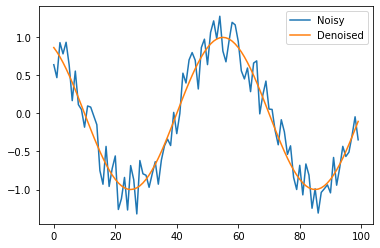

In [2]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

inp, out = sample(100)
plt.plot(inp, label='Noisy')
plt.plot(out, label ='Denoised')
plt.legend()

## Creating Dataset
Now, let's generate a dataset of such noisy and denoised samples, and divide it into train and test set.

In [3]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

## Bidirectional RNN

Bidirectional RNN is better than vanilla RNN on signal denosing. The input flows of Bidirectional RNN are in both directions, and it's capable of utilizing information from both sides.

In this example, we have 1d sine waves, which we want to denoise. Thus, we have input dimension of 1. Let's create a Bidirectional RNN with 30 hidden units. We can add dropout to prevent overfitting.

In [4]:
input_dim = 1
hidden_size = 60
num_layers = 1

bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred
        

rnn = CustomRNN(input_dim, hidden_size, 1).to(device)
rnn

/home/raph651/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CustomRNN(
  (rnn): RNN(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

## Training

In [10]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True).to(device)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) ).to(device)
    pred = rnn(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.cpu().numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data)
    loss.backward()
    optimizer.step()

0 tensor(0.6742, device='cuda:0')
20 tensor(0.0882, device='cuda:0')
40 tensor(0.0742, device='cuda:0')
60 tensor(0.0689, device='cuda:0')
80 tensor(0.0639, device='cuda:0')
100 tensor(0.0632, device='cuda:0')
120 tensor(0.0721, device='cuda:0')
140 tensor(0.0607, device='cuda:0')
160 tensor(0.0571, device='cuda:0')
180 tensor(0.0551, device='cuda:0')
200 tensor(0.0506, device='cuda:0')
220 tensor(0.0554, device='cuda:0')
240 tensor(0.0510, device='cuda:0')
260 tensor(0.0469, device='cuda:0')
280 tensor(0.0448, device='cuda:0')
300 tensor(0.0512, device='cuda:0')


## Prediction
Generating prediction on test set and visualizing the results

tensor(0.0532, device='cuda:0')


Text(0.5, 1.0, 'Sample num: 23')

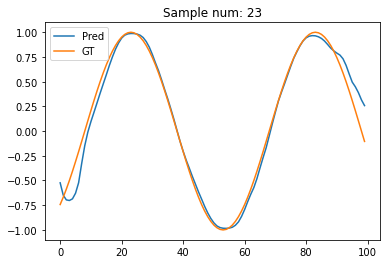

In [11]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True).to(device)
pred_t = rnn(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1)))).to(device)).data)

# Visualize
sample_num = 23
plt.plot(pred_t[sample_num].data.cpu().numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

### From RNNs to GRU

Let's now replace our RNN with GRU to see if the model improves.

In [12]:
input_dim = 1
hidden_size = 30
num_layers = 1


bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

gru = CustomRNN(input_dim, hidden_size, 1).to(device)
gru

/home/raph651/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CustomRNN(
  (rnn): GRU(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [13]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(gru.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(201):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True).to(device)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1)))).to(device)
    pred = gru(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.cpu().numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data)
    loss.backward()
    optimizer.step()

0 tensor(0.6566, device='cuda:0')
20 tensor(0.1097, device='cuda:0')
40 tensor(0.0768, device='cuda:0')
60 tensor(0.0668, device='cuda:0')
80 tensor(0.0580, device='cuda:0')
100 tensor(0.0516, device='cuda:0')
120 tensor(0.0461, device='cuda:0')
140 tensor(0.0444, device='cuda:0')
160 tensor(0.0412, device='cuda:0')
180 tensor(0.0375, device='cuda:0')
200 tensor(0.0361, device='cuda:0')


## Prediction
Generating prediction on test set and visualizing the results

tensor(0.0360, device='cuda:0')


Text(0.5, 1.0, 'Sample num: 23')

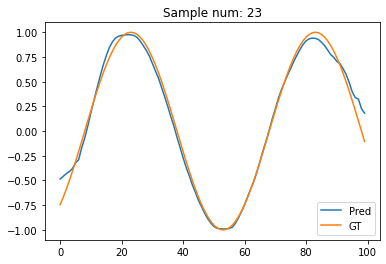

In [14]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True).to(device)
pred_t = gru(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1)))).to(device)).data)

# Visualize
sample_num = 23
plt.plot(pred_t[sample_num].data.cpu().numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

From the visualization, we can see GRU performs better than Bidirectional RNN.

### Visualization along the training process



fig size: 72.0 DPI, size in inches [4. 3.]


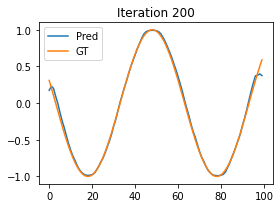

In [15]:
from matplotlib import animation, rc 

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(np.array(predictions)[i, 0, :, 0].T, label='Pred')
    ax.plot(train_out[0, :], label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = animation.FuncAnimation(fig, update, frames=range(0, 201, 10), interval=20)
rc('animation', html='jshtml')
anim